# TAD Calling

In [1]:
import os, json
import importlib
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import out_dire
from utils.data import DataTree

import snapfish2 as sf
importlib.reload(sf)

<module 'snapfish2' from '/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/__init__.py'>

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
dtree = DataTree("../data")

## Boundary overlap between original and noisy data

In [4]:
loader = sf.pp.FOF_CT_Loader({
    "rep1": dtree["takei_nature_2021", "25Kb", "rep1"],
    "rep2": dtree["takei_nature_2021", "25Kb", "rep2"]
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250})
noisy_loader = sf.pp.FOF_CT_Loader({
    "rep1": os.path.join(out_dire, "takei_nature_25kb_rep1.csv"),
    "rep2": os.path.join(out_dire, "takei_nature_25kb_rep2.csv")
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250})

In [6]:
count_df = []
for chr_id in loader.chr_ids:
    adata = loader.create_adata(chr_id)
    count_df.append([chr_id, adata.shape[0], np.mean(~np.isnan(adata.layers["X"]))])
count_df = pd.DataFrame(count_df, columns=["chr_id", "n_cells", "mean_count"])

In [6]:
count_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
chr_id,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,chr11,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19,chrX
n_cells,937,937,910,924,901,921,979,968,944,936,984,942,940,927,897,931,929,948,1045,483
mean_count,0.650125,0.543436,0.702198,0.637662,0.627026,0.618874,0.617314,0.663309,0.647811,0.659633,0.641396,0.613482,0.599681,0.684484,0.617874,0.633154,0.653014,0.604342,0.533365,0.671498


In [5]:
adata1 = loader.create_adata("chr1")
sf.pp.filter_normalize(adata1)
X = np.stack([adata1.layers[c] for c in ["X", "Y", "Z"]])
arr = X[:,:,:,None] - X[:,:,None,:]
med_diffr = np.nanmedian(np.abs(arr), axis=1)
adatan1 = noisy_loader.create_adata("chr1")
sf.pp.filter_normalize(adatan1)
X = np.stack([adatan1.layers[c] for c in ["X", "Y", "Z"]])
arr = X[:,:,:,None] - X[:,:,None,:]
med_diffn = np.nanmedian(np.abs(arr), axis=1)

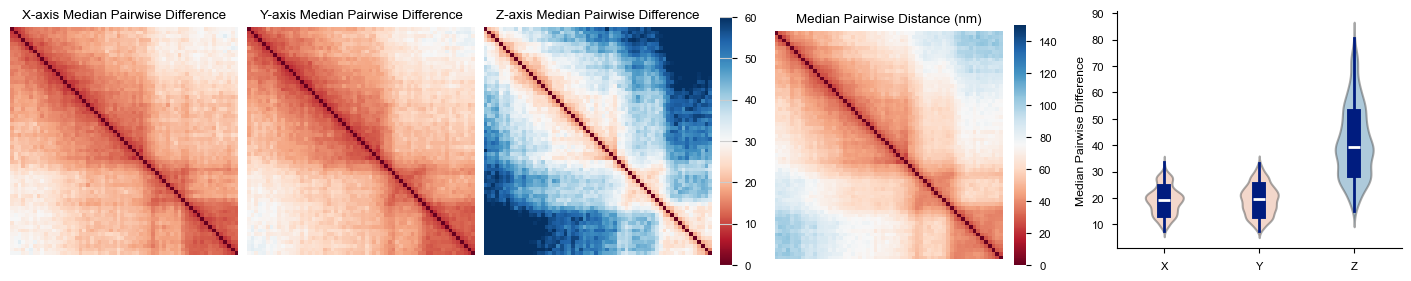

In [106]:
fig = plt.figure(figsize=(14, 2.7))
figs = fig.subfigures(1, 3, width_ratios=[9.05, 3.5, 4])
axes = figs[0].subplots(1, 4, width_ratios=[1, 1, 1, 0.05])
for i, (c, ax) in enumerate(zip(["X", "Y", "Z"], axes[:3])):
    sf.pl.pairwise_heatmap(med_diffr[i], cbar_ax=axes[-1], vmin=0, vmax=60, ax=ax)
    ax.set(title=f"{c}-axis Median Pairwise Difference")
ax = figs[1].subplots()
sf.pl.pairwise_heatmap(sf.pp.median_pdist(adata1, False), vmin=0, vmax=150, 
                       title="Median Pairwise Distance (nm)", ax=ax)

uidx = np.triu_indices_from(med_diffr[0], 1)
plt_df = (
    pd.DataFrame(med_diffr[:,*uidx], index=["X", "Y", "Z"]).T
    .melt(var_name="axis", value_name="diff")
)
ax = figs[2].subplots()
c1, c2 = plt.colormaps["RdBu"](80), plt.colormaps["RdBu"](200)
sns.violinplot(
    plt_df, x="axis", y="diff", hue="axis", width=0.4, 
    fill=True, alpha=0.5,
    palette={"X": c1, "Y": c1, "Z": c2}, linewidth=1.5, ax=ax,
    inner_kws=dict(box_width=10, whis_width=2, color=sns.color_palette("dark")[0])
)
ax.grid(False)
ax.set(xlabel="", ylabel="Median Pairwise Difference")
fig.savefig(os.path.join(out_dire, "takei_nature_25kb_pairwise_diff.pdf"), bbox_inches="tight")

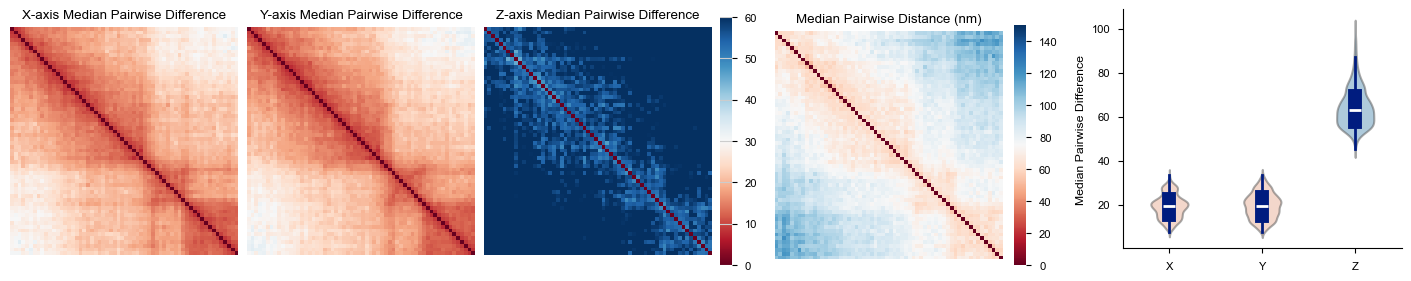

In [105]:
fig = plt.figure(figsize=(14, 2.7))
figs = fig.subfigures(1, 3, width_ratios=[9.05, 3.5, 4])
axes = figs[0].subplots(1, 4, width_ratios=[1, 1, 1, 0.05])
for i, (c, ax) in enumerate(zip(["X", "Y", "Z"], axes[:3])):
    sf.pl.pairwise_heatmap(med_diffn[i], cbar_ax=axes[-1], vmin=0, vmax=60, ax=ax)
    ax.set(title=f"{c}-axis Median Pairwise Difference")
ax = figs[1].subplots()
sf.pl.pairwise_heatmap(sf.pp.median_pdist(adatan1, False), vmin=0, vmax=150, 
                       title="Median Pairwise Distance (nm)", ax=ax)

uidx = np.triu_indices_from(med_diffn[0], 1)
plt_df = (
    pd.DataFrame(med_diffn[:,*uidx], index=["X", "Y", "Z"]).T
    .melt(var_name="axis", value_name="diff")
)
ax = figs[2].subplots()
c1, c2 = plt.colormaps["RdBu"](80), plt.colormaps["RdBu"](200)
sns.violinplot(
    plt_df, x="axis", y="diff", hue="axis", width=0.4, 
    fill=True, alpha=0.5,
    palette={"X": c1, "Y": c1, "Z": c2}, linewidth=1.5, ax=ax,
    inner_kws=dict(box_width=10, whis_width=2, color=sns.color_palette("dark")[0])
)
ax.grid(False)
ax.set(xlabel="", ylabel="Median Pairwise Difference")
fig.savefig(os.path.join(out_dire, "takei_nature_25kb_pairwise_diff_n.pdf"), bbox_inches="tight")

In [7]:
dete_eff = (count_df.n_cells*count_df.mean_count).sum()/count_df.n_cells.sum()
print(f"Detection efficiency: {dete_eff*100:.2f} cells per cell")

Detection efficiency: 62.93 cells per cell


In [6]:
res_sf1_path = os.path.join(out_dire, "tad_result_sf1.csv")
if not os.path.exists(res_sf1_path):
    tad = sf.tl.TADCaller(tree=False, method="insulation", 
                          prominence=0.04, distance=2)
    sf.wr.caller_wrapper(loader, tad=tad, tad_path=res_sf1_path)
res_sf1 = pd.read_csv(res_sf1_path, sep="\t")
res_sf2_path = os.path.join(out_dire, "tad_result_sf2.csv")
if not os.path.exists(res_sf2_path):
    tad = sf.tl.TADCaller(tree=False, method="pval")
    sf.wr.caller_wrapper(loader, tad=tad, tad_path=res_sf2_path)
res_sf2 = pd.read_csv(res_sf2_path, sep="\t")

In [7]:
res_sf1_noisy_path = os.path.join(out_dire, "tad_result_sf1_noisy.csv")
if not os.path.exists(res_sf1_noisy_path):
    tad = sf.tl.TADCaller(tree=False, method="insulation", 
                          prominence=0.04, distance=2)
    sf.wr.caller_wrapper(noisy_loader, tad=tad, tad_path=res_sf1_noisy_path)
res_sf1_noisy = pd.read_csv(res_sf1_noisy_path, sep="\t")
res_sf2_noisy_path = os.path.join(out_dire, "tad_result_sf2_noisy.csv")
if not os.path.exists(res_sf2_noisy_path):
    tad = sf.tl.TADCaller(tree=False, method="pval")
    sf.wr.caller_wrapper(noisy_loader, tad=tad, tad_path=res_sf2_noisy_path)
res_sf2_noisy = pd.read_csv(res_sf2_noisy_path, sep="\t")

In [8]:
from utils.utils import domain_output_to_boundary
domain_output_to_boundary(res_sf1_noisy)
overlap1 = sf.tl.signal_overlap(
    domain_output_to_boundary(res_sf1_noisy),
    domain_output_to_boundary(res_sf1),
)
a = 1 - overlap1.overlapped
print(f"Noisy specific: {np.sum(a)} ({(np.mean(a)*100).round(1)}%)")

Noisy specific: 22 (33.8%)


In [9]:
overlap2 = sf.tl.signal_overlap(
    domain_output_to_boundary(res_sf2_noisy),
    domain_output_to_boundary(res_sf2),
)
a = 1 - overlap2.overlapped
print(f"Noisy specific: {np.sum(a)} ({(np.mean(a)*100).round(1)}%)")

Noisy specific: 1 (1.1%)


In [10]:
shared1 = np.sum(overlap1.overlapped)
raw_df1 = domain_output_to_boundary(res_sf1)
shared2 = np.sum(overlap2.overlapped)
raw_df2 = domain_output_to_boundary(res_sf2)
df = pd.DataFrame({
    "Insulation": [shared1, len(overlap1) - shared1, len(raw_df1) - shared1],
    "SnapFISH2": [shared2, len(overlap2) - shared2, len(raw_df2) - shared2]
}).T
df.columns = ["Shared", "Raw Specific", "Noisy Specific"]
# shared_color = sns.color_palette("dark")[-2]
# raw_spe_color = sns.color_palette("dark")[0]
# noi_spe_color = sns.color_palette("dark")[3]

shared_color = plt.colormaps["RdBu"](100)
raw_spe_color = plt.colormaps["RdBu"](10)
noi_spe_color = plt.colormaps["RdBu"](240)

color=[shared_color, raw_spe_color, noi_spe_color]
df_norm = df.div(df.sum(axis=1), axis=0)

In [11]:
df_norm

,Shared,Raw Specific,Noisy Specific
Insulation,0.277419,0.141935,0.580645
SnapFISH2,0.885714,0.009524,0.104762


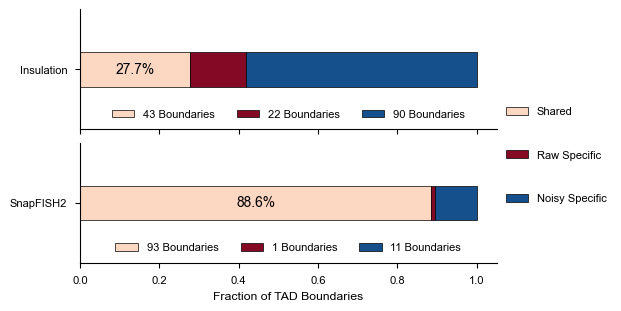

In [11]:
fig = plt.figure(figsize=(6, 3))
figs = fig.subfigures(1, 2, width_ratios=[1, .2])
axes = figs[0].subplots(2, 1, sharex=True)
df_norm.iloc[:1].plot(kind="barh", stacked=True, linewidth=.5, edgecolor="k",
                      color=color, width=0.2, ax=axes[0])
axes[0].grid(False)
lbls = [f"{n} Boundaries" for n in df.loc["Insulation"].values]
axes[0].legend(labels=lbls, loc="lower center", ncol=3)
bar = axes[0].patches[0]
axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_y()+bar.get_height()/2,
             f"{bar.get_width()*100:.1f}%", ha="center", verticalalignment="center")

df_norm.iloc[1:].plot(kind="barh", stacked=True, linewidth=.5, edgecolor="k",
                      color=color, width=0.2, ax=axes[1])
axes[1].grid(False)
lbls = [f"{n} Boundaries" for n in df.loc["SnapFISH2"].values]
axes[1].legend(labels=lbls, loc="lower center", ncol=3)
bar = axes[1].patches[0]
axes[1].text(bar.get_x()+bar.get_width()/2, bar.get_y()+bar.get_height()/2,
             f"{bar.get_width()*100:.1f}%", ha="center", verticalalignment="center")
axes[1].set_xlabel("Fraction of TAD Boundaries")

handles, labels = axes[1].get_legend_handles_labels()
figs[1].legend(handles, labels, loc="center", ncol=1, labelspacing=3)
fig.savefig(os.path.join(out_dire, "tad_overlap.pdf"), bbox_inches="tight")

## Example TAD calling

In [12]:
chr_id = "chr3"
adata = loader.create_adata(chr_id)
adata_noisy = noisy_loader.create_adata(chr_id)

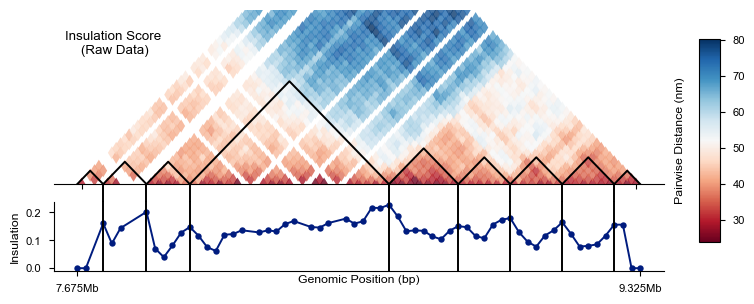

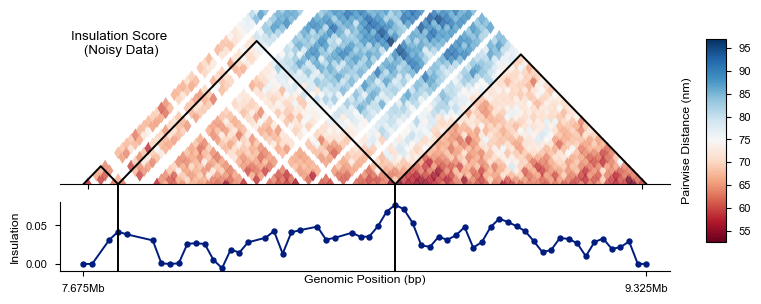

In [14]:
caller1 = sf.tl.TADCaller(tree=False, method="insulation", 
                         prominence=0.04, distance=2)
fig = plt.figure(figsize=(7, 2.7))
ax, cbar, cax = sf.pl.triangle_domain_boundary(adata, caller1, fig=fig)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"Insulation Score \n(Raw Data)", y=0.7, x=0.1)
fig.savefig(os.path.join(out_dire, "triangle_tad_insulation_raw.pdf"), bbox_inches="tight")

fig = plt.figure(figsize=(7, 2.7))
ax, cbar, cax = sf.pl.triangle_domain_boundary(adata_noisy, caller1, fig=fig)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"Insulation Score \n(Noisy Data)", y=0.7, x=0.1)
fig.savefig(os.path.join(out_dire, "triangle_tad_insulation_noi.pdf"), bbox_inches="tight")

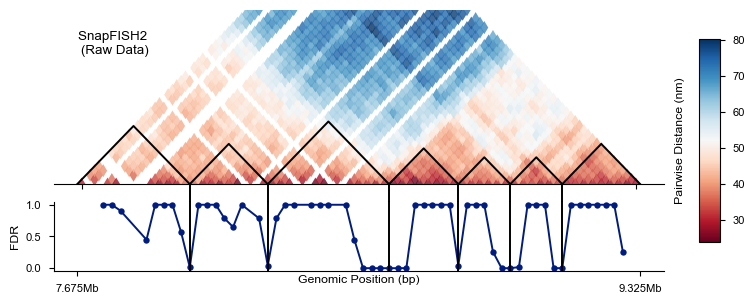

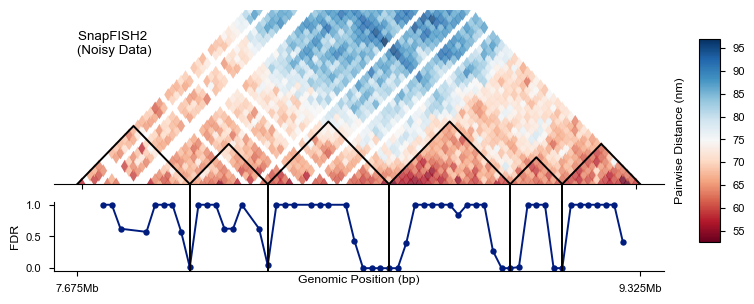

In [15]:
caller2 = sf.tl.TADCaller(tree=False, method="pval", fdr_cutoff=.1)
fig = plt.figure(figsize=(7, 2.7))
ax, cbar, cax = sf.pl.triangle_domain_boundary(adata, caller2, fig=fig)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"SnapFISH2 \n(Raw Data)", y=0.7, x=0.1)
fig.savefig(os.path.join(out_dire, "triangle_tad_pval_raw.pdf"), bbox_inches="tight")

fig = plt.figure(figsize=(7, 2.7))
ax, cbar, cax = sf.pl.triangle_domain_boundary(adata_noisy, caller2, fig=fig)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"SnapFISH2 \n(Noisy Data)", y=0.7, x=0.1)
fig.savefig(os.path.join(out_dire, "triangle_tad_pval_noi.pdf"), bbox_inches="tight")

In [109]:
insu_path = os.path.join(out_dire, "tad_insulation.csv")
pval_path = os.path.join(out_dire, "tad_pval.csv")
dfs = {"Insulation": [], "SnapFISH2": []}
if not os.path.exists(insu_path):
    for c in loader.chr_ids:
        adata = loader.create_adata(c)
        adata_noisy = noisy_loader.create_adata(c)
        
        df1 = caller1.call_tads(adata)
        df1 = df1[df1["insulation"] > 0]
        df2 = caller1.call_tads(adata_noisy)
        df2 = df2[df2["insulation"] > 0]
        dfs["Insulation"].append(pd.merge(
            df1, df2, on=["c1", "Chrom_Start", "Chrom_End"],
        ))
        
        df1 = caller2.call_tads(adata).dropna()
        df2 = caller2.call_tads(adata_noisy).dropna()
        dfs["SnapFISH2"].append(pd.merge(
            df1, df2, on=["c1", "Chrom_Start", "Chrom_End"],
        ))
    dfs["Insulation"] = pd.concat(dfs["Insulation"])
    dfs["SnapFISH2"] = pd.concat(dfs["SnapFISH2"])
    dfs["Insulation"].to_csv(insu_path, index=False)
    dfs["SnapFISH2"].to_csv(pval_path, index=False)
else:
    dfs["Insulation"] = pd.read_csv(insu_path)
    dfs["SnapFISH2"] = pd.read_csv(pval_path)

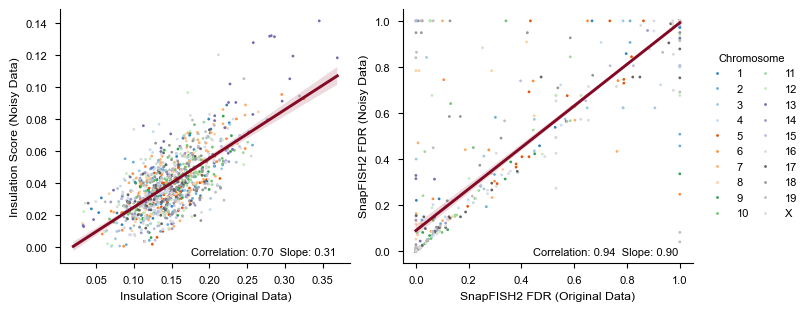

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), width_ratios=[1, 1, 0.2])

insu = dfs["Insulation"].copy()
sns.scatterplot(insu, x="insulation_x", y="insulation_y", hue="c1",
                s=4, linewidth=0, palette="tab20c", ax=axes[0])
sns.regplot(insu, x="insulation_x", y="insulation_y",
            scatter=False, color=raw_spe_color, ax=axes[0])
axes[0].grid(False)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].get_legend().remove()
r, p = stats.pearsonr(insu["insulation_x"], insu["insulation_y"])
s = stats.linregress(insu["insulation_x"], insu["insulation_y"]).slope
axes[0].text(
    0.95, 0.02,
    f"Correlation: {r:.2f}  Slope: {s:.2f}",
    transform=axes[0].transAxes,
    fontsize=8,
    verticalalignment="bottom",
    horizontalalignment="right"
)
axes[0].set(xlabel="Insulation Score (Original Data)",
            ylabel="Insulation Score (Noisy Data)")

fdr = dfs["SnapFISH2"].reset_index(drop=True)
sns.scatterplot(fdr, x="fdr_x", y="fdr_y", hue="c1",
                s=4, linewidth=0, palette="tab20c", ax=axes[1])
sns.regplot(fdr, x="fdr_x", y="fdr_y", robust=False,
            scatter=False, color=raw_spe_color, ax=axes[1])
axes[1].grid(False)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].get_legend().remove()
r, p = stats.pearsonr(fdr["fdr_x"], fdr["fdr_y"])
s = stats.linregress(fdr["fdr_x"], fdr["fdr_y"]).slope
axes[1].text(
    0.95, 0.02,
    f"Correlation: {r:.2f}  Slope: {s:.2f}",
    transform=axes[1].transAxes,
    fontsize=8,
    verticalalignment="bottom",
    horizontalalignment="right"
)
axes[1].set(xlabel="SnapFISH2 FDR (Original Data)",
            ylabel="SnapFISH2 FDR (Noisy Data)")

labels = [l[3:] for l in labels]
axes[2].legend(handles, labels, title="Chromosome", title_fontsize=8,
               ncol=2, loc="center", columnspacing=.4)
axes[2].axis("off")

fig.savefig(os.path.join(out_dire, "tad_correlation.pdf"), bbox_inches="tight")

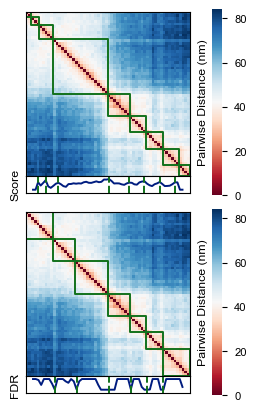

In [5]:
chr_id = "chr3"
adata = loader.create_adata(chr_id)

fig, axes = plt.subplots(2, 1, figsize=(2.3, 4))
caller = sf.tl.TADCaller(tree=False, method="insulation", 
                         prominence=0.04, distance=2)
sf.pl.domain_boundary(adata, caller, ax=axes[0])
caller = sf.tl.TADCaller(tree=False, method="pval")
sf.pl.domain_boundary(adata, caller, ax=axes[1])
for ax in axes:
    cbar = ax.collections[0].colorbar
    cbar.set_label("Pairwise Distance (nm)", labelpad=-35)    
fig.savefig(os.path.join(out_dire, f"{chr_id}_TAD.pdf"), bbox_inches="tight")

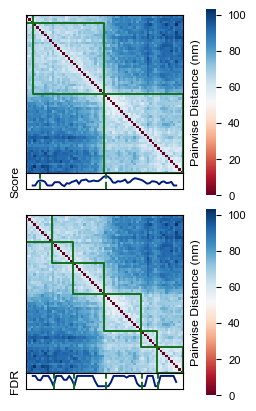

In [6]:
chr_id = "chr3"
adata = noisy_loader.create_adata(chr_id)

fig, axes = plt.subplots(2, 1, figsize=(2.3, 4))
caller = sf.tl.TADCaller(tree=False, method="insulation", 
                         prominence=0.04, distance=2)
sf.pl.domain_boundary(adata, caller, ax=axes[0])
caller = sf.tl.TADCaller(tree=False, method="pval")
sf.pl.domain_boundary(adata, caller, ax=axes[1])
for ax in axes:
    cbar = ax.collections[0].colorbar
    cbar.set_label("Pairwise Distance (nm)", labelpad=-40)
fig.savefig(os.path.join(out_dire, f"{chr_id}_TAD_noisy.pdf"), bbox_inches="tight")

## Correlation with ChIP-seq

In [110]:
from utils.maps import cpmt_enrichment
res1 = dfs["Insulation"].rename({
    "Chrom_Start": "s1", "Chrom_End": "e1",
    "peak_x": "cpmt"
}, axis=1)[["c1", "s1", "e1", "cpmt"]]
res2 = dfs["Insulation"].rename({
    "Chrom_Start": "s1", "Chrom_End": "e1",
    "peak_y": "cpmt"
}, axis=1)[["c1", "s1", "e1", "cpmt"]]

In [111]:
from utils.utils import domain_chipseq_df
markers = dtree["chipseq_mesc"].keys()
raw_enrich_path = os.path.join(out_dire, "tad_raw_enrich_chipseq.csv")
if not os.path.exists(raw_enrich_path):
    raw_enrich_df = domain_chipseq_df(dtree, loader, res_sf1, res_sf2, markers)
    raw_enrich_df.to_csv(raw_enrich_path, index=False, sep="\t")
raw_enrich_df = pd.read_csv(raw_enrich_path, sep="\t")
noi_enrich_path = os.path.join(out_dire, "tad_noi_enrich_chipseq.csv")
if not os.path.exists(noi_enrich_path):
    noi_enrich_df = domain_chipseq_df(dtree, noisy_loader, res_sf1_noisy, res_sf2_noisy, markers)
    noi_enrich_df.to_csv(noi_enrich_path, index=False, sep="\t")
noi_enrich_df = pd.read_csv(noi_enrich_path, sep="\t")

In [112]:
raw_enrich_df

,frac,num,total,marker,Method
0,0.310000,372,1200,H3K4me3,Average
1,0.409167,491,1200,H3K4me1,Average
2,0.247500,297,1200,H3K27ac,Average
3,0.230833,277,1200,H3K36me3,Average
4,0.040833,49,1200,H3K9me3,Average
5,0.293333,352,1200,H3K9ac,Average
6,0.298333,358,1200,CTCF,Average
7,0.120833,145,1200,POLR2A,Average
8,0.368421,49,133,H3K4me3,SnapFISH
9,0.413534,55,133,H3K4me1,SnapFISH


In [113]:
noi_enrich_df

,frac,num,total,marker,Method
0,0.310000,372,1200,H3K4me3,Average
1,0.409167,491,1200,H3K4me1,Average
2,0.247500,297,1200,H3K27ac,Average
3,0.230833,277,1200,H3K36me3,Average
4,0.040833,49,1200,H3K9me3,Average
5,0.293333,352,1200,H3K9ac,Average
6,0.298333,358,1200,CTCF,Average
7,0.120833,145,1200,POLR2A,Average
8,0.369231,24,65,H3K4me3,SnapFISH
9,0.384615,25,65,H3K4me1,SnapFISH


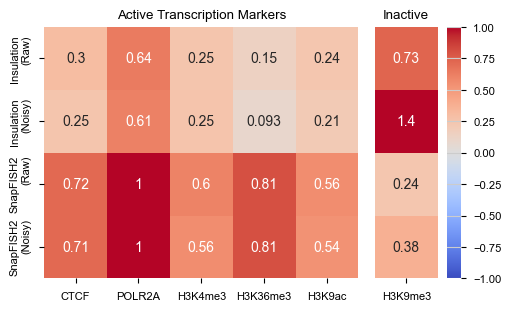

In [114]:
dfr = pd.merge(raw_enrich_df[raw_enrich_df["Method"]!="Average"], 
               raw_enrich_df[raw_enrich_df["Method"]=="Average"], on="marker")
dfr["fold"] = np.log2(dfr["frac_x"]/dfr["frac_y"])
dfr["type"] = "Raw"

dfn = pd.merge(noi_enrich_df[noi_enrich_df["Method"]!="Average"], 
               noi_enrich_df[noi_enrich_df["Method"]=="Average"], on="marker")
dfn["fold"] = np.log2(dfn["frac_x"]/dfn["frac_y"])
dfn["type"] = "Noisy"
df = pd.concat([dfr, dfn])[["marker", "fold", "type", "Method_x"]]
df.rename(columns={"Method_x": "Method"}, inplace=True)
df["Method"] = df["Method"].map({"SnapFISH": "Insulation", "SnapFISH2": "SnapFISH2"})
df["row"] = df["Method"] + "\n(" + df["type"] + ")"
plt_df = df.pivot(index="row", columns="marker", values="fold").T
plt_df = plt_df[["Insulation\n(Raw)", "Insulation\n(Noisy)", \
    "SnapFISH2\n(Raw)", "SnapFISH2\n(Noisy)"]]

up_rglt = ["CTCF", "POLR2A", "H3K4me3", "H3K36me3", "H3K9ac"]
down_rglt = ["H3K9me3"]
             
fig, axes = plt.subplots(1, 3, figsize=(len(up_rglt+down_rglt)*3/3.6,3), 
                             width_ratios=[len(up_rglt),len(down_rglt),.2])
sns.heatmap(plt_df.T[up_rglt], vmin=-1, vmax=1, annot=True, square=True,
            cmap="coolwarm", cbar=False, ax=axes[0])
labels = axes[0].get_xticklabels()
axes[0].set_xticklabels(labels, ha="center")
axes[0].set(title="Active Transcription Markers", xlabel="", ylabel="")
axes[0].grid(False)
sns.heatmap(plt_df.T[down_rglt], vmin=-1, vmax=1, annot=True, square=True,
            cmap="coolwarm", yticklabels=False, ax=axes[1], cbar_ax=axes[2])
axes[1].set(title="Inactive", xlabel="", ylabel="")
axes[1].grid(False)
fig.savefig(os.path.join(out_dire, "tad_chipseq_enrich.pdf"), bbox_inches="tight")

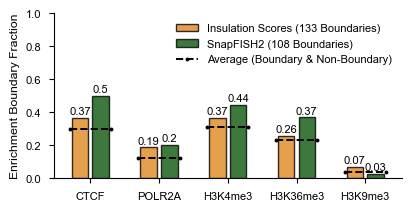

In [378]:
from utils.lines import domain_chipseq_barplot
fig, ax = plt.subplots(figsize=(4, 2))
domain_chipseq_barplot(raw_enrich_df, ax=ax)
fig.savefig(os.path.join(out_dire, "tad_raw_enrich_chipseq.pdf"), bbox_inches="tight")

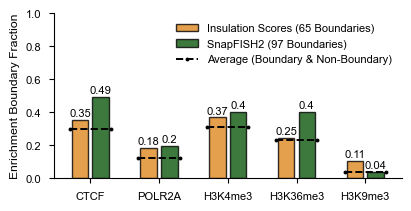

In [11]:
fig, ax = plt.subplots(figsize=(4, 2))
domain_chipseq_barplot(noi_enrich_df, ax=ax)
fig.savefig(os.path.join(out_dire, "tad_noi_enrich_chipseq.pdf"), bbox_inches="tight")

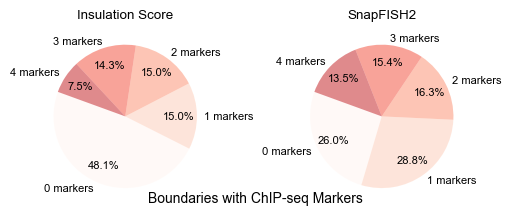

In [134]:
from utils.utils import domain_add_chipseq_col

colors = [plt.get_cmap("Reds")(i*50) for i in range(5)]
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))

res = res_sf1.copy()
for marker in ["CTCF", "POLR2A", "H3K4me3", "H3K36me3"]:
    res = domain_add_chipseq_col(res, marker, dtree)
labels, count = np.unique(res.iloc[:, 3:].sum(axis=1), return_counts=True)
axes[0].pie(
    count, labels=[f"{t} markers" for t in labels], textprops={"fontsize":8},
    autopct="%1.1f%%", startangle=160, labeldistance=1.1, pctdistance=.75,
    wedgeprops={"alpha": .5}, colors=colors,
)
axes[0].set_title("Insulation Score")

res = res_sf2.copy()
for marker in ["CTCF", "POLR2A", "H3K4me3", "H3K36me3"]:
    res = domain_add_chipseq_col(res, marker, dtree)
labels, count = np.unique(res.iloc[:, 3:].sum(axis=1), return_counts=True)
axes[1].pie(
    count, labels=[f"{t} markers" for t in labels], textprops={"fontsize":8},
    autopct="%1.1f%%", startangle=160, labeldistance=1.1, pctdistance=.75, 
    wedgeprops={"alpha": .5}, colors=colors
)
axes[1].set_title("SnapFISH2")

fig.suptitle("Boundaries with ChIP-seq Markers", y=0.2, fontsize=10)
fig.savefig(os.path.join(out_dire, "tad_marker_pie.pdf"), bbox_inches="tight")

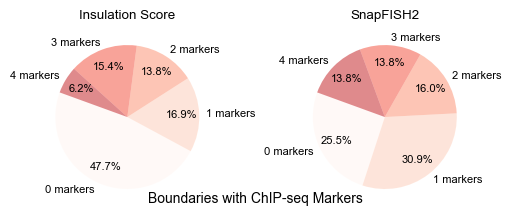

In [135]:
from utils.utils import domain_add_chipseq_col

colors = [plt.get_cmap("Reds")(i*50) for i in range(5)]
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))

res = res_sf1_noisy.copy()
for marker in ["CTCF", "POLR2A", "H3K4me3", "H3K36me3"]:
    res = domain_add_chipseq_col(res, marker, dtree)
labels, count = np.unique(res.iloc[:, 3:].sum(axis=1), return_counts=True)
axes[0].pie(
    count, labels=[f"{t} markers" for t in labels], textprops={"fontsize":8},
    autopct="%1.1f%%", startangle=160, labeldistance=1.1, pctdistance=.75,
    wedgeprops={"alpha": .5}, colors=colors,
)
axes[0].set_title("Insulation Score")

res = res_sf2_noisy.copy()
for marker in ["CTCF", "POLR2A", "H3K4me3", "H3K36me3"]:
    res = domain_add_chipseq_col(res, marker, dtree)
labels, count = np.unique(res.iloc[:, 3:].sum(axis=1), return_counts=True)
axes[1].pie(
    count, labels=[f"{t} markers" for t in labels], textprops={"fontsize":8},
    autopct="%1.1f%%", startangle=160, labeldistance=1.1, pctdistance=.75, 
    wedgeprops={"alpha": .5}, colors=colors
)
axes[1].set_title("SnapFISH2")

fig.suptitle("Boundaries with ChIP-seq Markers", y=0.2, fontsize=10)
fig.savefig(os.path.join(out_dire, "tad_marker_pie_noisy.pdf"), bbox_inches="tight")

## Overlap with Hi-C

In [56]:
import pyBigWig

df = loader.read_data()["rep1"].groupby("Chrom", sort=False)
chr_range = pd.merge(
    df["Chrom_Start"].min().reset_index(),
    df["Chrom_End"].max().reset_index(),
    on="Chrom"
).set_index("Chrom")

hic_insu = []
with pyBigWig.open(dtree["bonev_cell_2017","G0G1_mESC_GFP+","insulation"]) as bw:
    for chr_id, row in chr_range.iterrows():
        val = bw.values(chr_id, row["Chrom_Start"], row["Chrom_End"])
        x = np.linspace(row["Chrom_Start"], row["Chrom_End"], len(val))
        # bw is for each bp. Convert to 5kb resolution
        df = pd.DataFrame({"s1": x, "insulation": val}).iloc[::5000]
        df["c1"] = chr_id
        df["e1"] = df["s1"] + 5000
        df = df.astype({"s1": "int64", "e1": "int64"})
        hic_insu.append(df[["c1", "s1", "e1", "insulation"]])
hic_insu = pd.concat(hic_insu, ignore_index=True)

boundaries = pd.read_csv(
    dtree["bonev_cell_2017","G0G1_mESC_GFP+","boundaries"], 
    sep="\t", header=None, names=["c1", "s1", "e1", "strength", "val"],
)
hic_insu = pd.merge(hic_insu, boundaries, on=["c1", "s1", "e1"], how="left")
hic_insu["peak"] = ~hic_insu["strength"].isna()

In [57]:
caller2.method

'pval'

(191700183.91357896, 193955854.54556406)

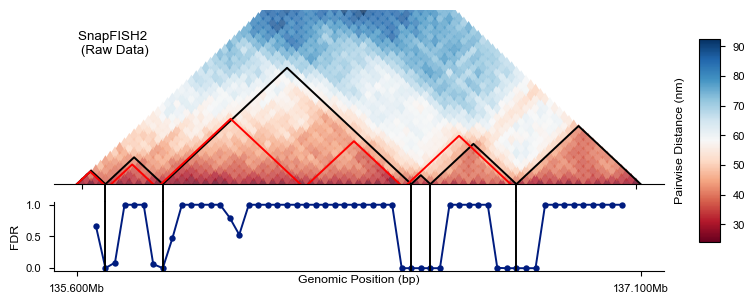

In [229]:
adata = loader.create_adata("chr1")
fig = plt.figure(figsize=(7, 2.7))
ax, cbar, cax = sf.pl.triangle_domain_boundary(adata, caller2, fig=fig)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"SnapFISH2 \n(Raw Data)", y=0.7, x=0.1)

caller = sf.tl.TADCaller(tree=False, method="insulation", 
                         prominence=0.04, distance=2)
df = hic_insu.rename({"s1": "Chrom_Start", "e1": "Chrom_End"}, axis=1)
for _, row in caller.to_bedpe(df).iterrows():
    # Move .5 bin up
    s = (row.s1 + row.e1)/2 - (row.e1 - row.s1)/2
    e = (row.s2 + row.e2)/2 + (row.e2 - row.s2)/2
    df = sf.pl.rotate_df(pd.DataFrame({"x": [e,s,s], "y": [e,e,s]}))
    ax.plot(df.x_rot, df.y_rot, color="red")
ax.set_xlim(*cax.get_xlim())

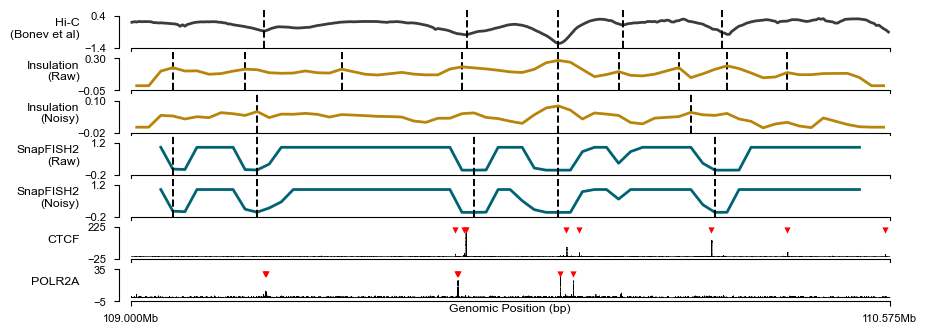

In [59]:
chr_id = "chr2"
plt.rcParams["axes.grid"] = False
# plt.rcParams["axes.spines.bottom"] = False
axes = []
c1, c2, c3 = sns.color_palette("dark")[-3:]
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
hic_sub = hic_insu[hic_insu["c1"]==chr_id].copy()
hic_sub["mid"] = (hic_sub["s1"] + hic_sub["e1"])/2
sns.lineplot(hic_sub, x="mid", y="insulation", color=c1, linewidth=2, ax=ax)
for x in hic_sub.dropna().mid:
    ax.axvline(x, ymin=0, ymax=1, linestyle="--", color="k", clip_on=False)
axes_divider = make_axes_locatable(ax)
ax.set_ylabel("Hi-C\n(Bonev et al)", rotation=0, ha="right", va="center")
axes.append(ax)
    
adata = loader.create_adata(chr_id)
insu_sub = caller1.call_tads(adata)
insu_sub["mid"] = (insu_sub["Chrom_Start"] + insu_sub["Chrom_End"])/2
cax = axes_divider.append_axes("bottom", size="100%", pad="10%")
sns.lineplot(insu_sub, x="mid", y="insulation", color=c2, linewidth=2, ax=cax)
for x in insu_sub[insu_sub.peak].mid:
    cax.axvline(x, ymin=0, ymax=1, linestyle="--", color="k", clip_on=False, zorder=0)
cax.set_ylabel("Insulation\n(Raw)", rotation=0, ha="right", va="center")
axes.append(cax)
    
adatan = noisy_loader.create_adata(chr_id)
insu_sub = caller1.call_tads(adatan)
insu_sub["mid"] = (insu_sub["Chrom_Start"] + insu_sub["Chrom_End"])/2
cax = axes_divider.append_axes("bottom", size="100%", pad="10%")
sns.lineplot(insu_sub, x="mid", y="insulation", color=c2, linewidth=2, ax=cax)
for x in insu_sub[insu_sub.peak].mid:
    cax.axvline(x, ymin=0, ymax=1, linestyle="--", color="k", clip_on=False, zorder=0)
cax.set_ylabel("Insulation\n(Noisy)", rotation=0, ha="right", va="center")
axes.append(cax)
    
sf2_sub = caller2.call_tads(adata)
sf2_sub["mid"] = (sf2_sub["Chrom_Start"] + sf2_sub["Chrom_End"])/2
cax = axes_divider.append_axes("bottom", size="100%", pad="10%")
sns.lineplot(sf2_sub, x="mid", y="fdr", color=c3, linewidth=2, ax=cax)
for x in sf2_sub[sf2_sub.peak].mid:
    cax.axvline(x, ymin=0, ymax=1, linestyle="--", color="k", clip_on=False)
cax.set_ylabel("SnapFISH2\n(Raw)", rotation=0, ha="right", va="center")
axes.append(cax)

sf2_sub = caller2.call_tads(adatan)
sf2_sub["mid"] = (sf2_sub["Chrom_Start"] + sf2_sub["Chrom_End"])/2
cax = axes_divider.append_axes("bottom", size="100%", pad="10%")
sns.lineplot(sf2_sub, x="mid", y="fdr", color=c3, linewidth=2, ax=cax)
for x in sf2_sub[sf2_sub.peak].mid:
    cax.axvline(x, ymin=0, ymax=1, linestyle="--", color="k", clip_on=False)
cax.set_ylabel("SnapFISH2\n(Noisy)", rotation=0, ha="right", va="center")
axes.append(cax)

s, e = adata.var["Chrom_Start"].min(), adata.var["Chrom_End"].max()
for marker in ["CTCF", "POLR2A"]:
    with pyBigWig.open(dtree["chipseq_mesc",marker,"bigWig"]) as bw:
        val = bw.values(chr_id, s, e)
    df = pd.DataFrame({"s1": np.arange(s, e), marker: val})
    df = df[df[marker] != df[marker].shift()]
    df["e1"] = df["s1"].shift(-1)
    df.iloc[-1,-1] = e
    df = pd.concat([
        df[["s1", marker]],
        df[["e1", marker]].rename({"e1": "s1"}, axis=1)
    ]).sort_values("s1")
    cax = axes_divider.append_axes("bottom", size="100%", pad="10%")
    cax.fill_between(df["s1"], df[marker], alpha=1, color="k")
    
    peaks = pd.read_csv(dtree["chipseq_mesc", marker, "peak"], sep="\t",
                        header=None, usecols=[0, 1, 2], names=["c1", "s1", "e1"])
    peaks = peaks[(peaks["c1"]==chr_id)&(peaks["s1"]>=s)&(peaks["e1"]<=e)]
    peaks["y"] = cax.get_ylim()[1]
    peaks["mid"] = (peaks["s1"] + peaks["e1"])/2
    sns.scatterplot(peaks, x="mid", y="y", s=20, linewidth=0,
                    marker="v", color="r", ax=cax)
    cax.set_ylabel(marker, rotation=0, ha="right", va="center")
    axes.append(cax)
for ax in axes:
    ax.set(xticks=[s, e], xlim=(s-25e3, e+25e3), xticklabels=[])
    ax.spines.bottom.set_bounds(s, e)
    yticks = ax.get_yticks()
    yrange = yticks[-1] - yticks[0]
    ax.set(yticks=[yticks[0], yticks[-1]], 
           ylim=(yticks[0], yticks[-1]+yrange*0.2))
    ax.spines.left.set_bounds(yticks[0], yticks[-1])
    ax.yaxis.set_label_coords(-0.05, .5)
cax.set(
    xlabel="Genomic Position (bp)", xticks=[s, e],
    xticklabels=[f"{s/1e6:.3f}Mb", f"{e/1e6:.3f}Mb"]
)
cax.xaxis.set_label_coords(0.5, -.05)
    
plt.rcParams["axes.grid"] = True
fig.savefig(os.path.join(out_dire, f"{chr_id}_TAD_chipseq.pdf"), bbox_inches="tight")

In [351]:
hic_peak = []
for chr_id, df in hic_insu.groupby("c1", sort=False):
    df["group"] = np.repeat(np.arange(int(len(df)/5)), 5)
    peak = df.groupby("group")["peak"].sum() > 0
    df = df[::5].copy()
    df["peak"] = peak.values
    hic_peak.append(df)
hic_peak = pd.concat(hic_peak, ignore_index=True)


,c1,s1,e1,insulation,strength,val,peak,group
3,chr1,135675000,135680000,-0.112400,NaN,NaN,True,3
8,chr1,135800000,135805000,0.069550,NaN,NaN,True,8
24,chr1,136200000,136205000,-0.050383,NaN,NaN,True,24
34,chr1,136450000,136455000,-0.143990,NaN,NaN,True,34
46,chr1,136750000,136755000,-0.583209,NaN,NaN,True,46
...,...,...,...,...,...,...,...,...
1174,chr19,12575000,12580000,0.083097,NaN,NaN,True,1
1183,chr19,12800000,12805000,-0.807927,NaN,NaN,True,10
1226,chr19,13875000,13880000,-0.379667,NaN,NaN,True,53
1247,chr19,14400000,14405000,-0.394380,NaN,NaN,True,74


In [354]:
from utils.utils import _domain_chipseq_row
hic_chip_df = {}
for m in dtree["chipseq_mesc"].keys():
    f1 = _domain_chipseq_row(dtree, m, hic_peak[hic_peak.peak])["frac"]
    f2 = _domain_chipseq_row(dtree, m, hic_peak)["frac"]
    hic_chip_df[m] = [np.log2(f1/f2)]
pd.DataFrame(hic_chip_df)

,H3K4me3,H3K4me1,H3K27ac,H3K36me3,H3K9me3,H3K9ac,CTCF,POLR2A
0,0.992923,0.506721,1.202715,0.744424,0.824203,0.889927,0.92708,1.896612


## Su et al, Chromosome 21

In [116]:
import anndata as ad
loader = sf.pp.FOF_CT_Loader(f"../data/su_cell_2020/chromosome21.csv")
p21 = os.path.join(out_dire, "chromosome21.h5ad")
if not os.path.exists(p21):
    adata = loader.create_adata("chr21")
    sf.tl.median_pdist(adata, inplace=True)
    sf.pp.filter_normalize(adata)
    adata.write_h5ad(p21, compression="gzip")
else:
    adata = ad.read_h5ad(p21)

<Axes: ylabel='stat'>

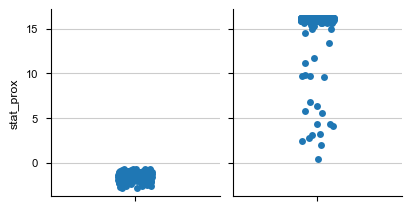

In [124]:
caller_21_insu = sf.tl.TADCaller(tree=False, method="insulation",
                                 prominence=0.025, distance=5, window=3e5)
res_insu = caller_21_insu.call_tads(adata)
caller_21_pval = sf.tl.TADCaller(tree=False, method="pval", window=3e5)
res_pval = caller_21_pval.call_tads(adata)
fig, axes = plt.subplots(1, 2, figsize=(4, 2), sharey=True)
sns.stripplot(np.log10(res_pval.stat_prox), ax=axes[0])
sns.stripplot(np.log10(res_pval.stat), ax=axes[1])

In [127]:
res_insu.peak.sum(), res_pval.peak.sum()

(53, 51)

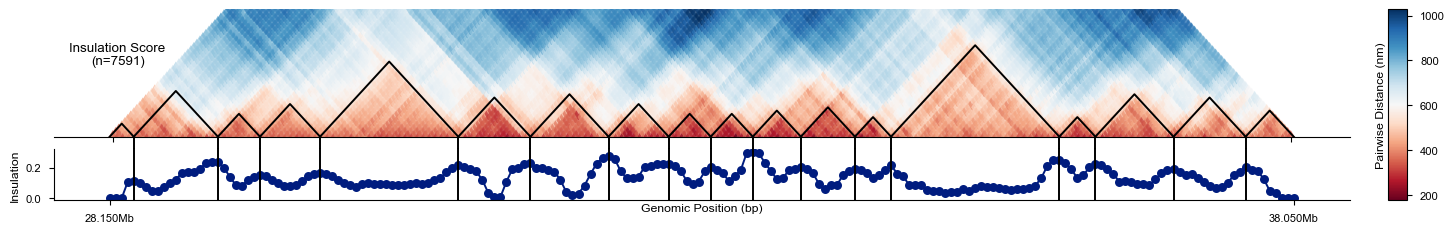

In [118]:
fig = plt.figure(figsize=(14, 2))
sub_adata = adata[:,adata.var["Chrom_Start"] >= 28.15e6]
sub_adata = sub_adata[:,sub_adata.var["Chrom_End"] <= 38.1e6]
ax, cbar, cax = sf.pl.triangle_domain_boundary(sub_adata, caller_21_insu, fig=fig, cut_hi=2e6)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"Insulation Score \n(n=7591)", y=0.5, x=0.05)
fig.savefig(os.path.join(out_dire, "triangle_tad_insulation_21.pdf"), bbox_inches="tight")

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:183: RuntimeWarning: Mean of empty slice
  x0 = x - np.nanmean(x, axis=1)[:,None]


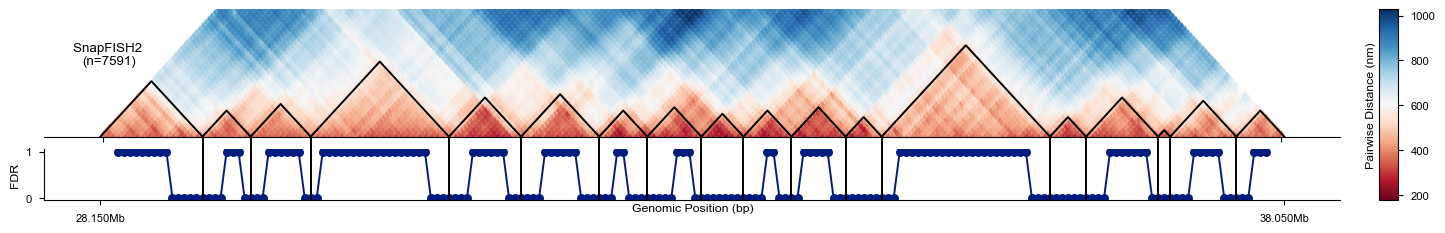

In [119]:
fig = plt.figure(figsize=(14, 2))
sub_adata = adata[:,adata.var["Chrom_Start"] >= 28.15e6]
sub_adata = sub_adata[:,sub_adata.var["Chrom_End"] <= 38.1e6]
ax, cbar, cax = sf.pl.triangle_domain_boundary(sub_adata, caller_21_pval, fig=fig, cut_hi=2e6)
cbar.set_label("Pairwise Distance (nm)", labelpad=-50)
ax.set_title(f"SnapFISH2 \n(n=7591)", y=0.5, x=0.05)
fig.savefig(os.path.join(out_dire, "triangle_tad_pval_21.pdf"), bbox_inches="tight")

In [120]:
sf.pp.axis_weight(adata, inplace=False)

array([0.23864351, 0.25022305, 0.51113344])

In [121]:
res_pval.peak.sum()

51

In [122]:
from utils.utils import domain_chipseq_df

markers = dtree["chipseq_imr90"].keys()
enrich_21 = domain_chipseq_df(
    dtree, loader, caller_21_insu.to_bedpe(res_insu), 
    caller_21_pval.to_bedpe(res_pval), markers, "chipseq_imr90"
)

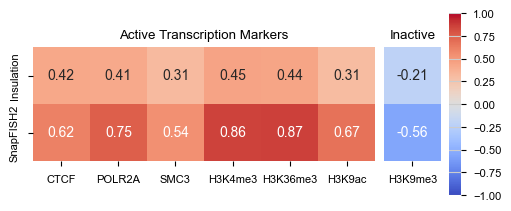

In [123]:
up_rglt = ["CTCF", "POLR2A", "SMC3", "H3K4me3", "H3K36me3", "H3K9ac"]
down_rglt = ["H3K9me3"]
dfr = pd.merge(enrich_21[enrich_21["Method"]!="Average"], 
               enrich_21[enrich_21["Method"]=="Average"], on="marker")
dfr["fold"] = np.log2(dfr["frac_x"]/dfr["frac_y"])
dfr["type"] = "Raw"
dfr.rename(columns={"Method_x": "Method"}, inplace=True)
dfr["Method"] = dfr["Method"].map({"SnapFISH": "Insulation", "SnapFISH2": "SnapFISH2"})
plt_df = dfr.pivot(index="Method", columns="marker", values="fold")

fig, axes = plt.subplots(1, 3, figsize=(5, 2), width_ratios=[6, 1, .2])
sns.heatmap(plt_df[up_rglt], vmin=-1, vmax=1, annot=True, square=True,
            cmap="coolwarm", cbar=False, ax=axes[0])
labels = axes[0].get_xticklabels()
axes[0].set_xticklabels(labels, ha="center")
axes[0].set(title="Active Transcription Markers", xlabel="", ylabel="")
axes[0].grid(False)
sns.heatmap(plt_df[down_rglt], vmin=-1, vmax=1, annot=True, square=True,
            cmap="coolwarm", yticklabels=False, ax=axes[1], cbar_ax=axes[2])
axes[1].set(title="Inactive", xlabel="", ylabel="")
axes[1].grid(False)
fig.savefig(os.path.join(out_dire, "tad_chipseq_enrich_21.pdf"), bbox_inches="tight")

scp hongyuyu@longleaf.unc.edu:/proj/yunligrp/users/hongyuyu/AxisWiseTest/123ACElog/051625/tad_replicate_21.csv 123ACElog/051625/tad_replicate_21.csv 

In [32]:
res = caller_21_pval.call_tads(adata)
res["num_cells"] = adata.shape[0]
res["replicate"] = -1
reps = [res]

for f in os.listdir(out_dire):
    if f.startswith("replicate_") and f.endswith(".csv"):
        rep = pd.read_csv(os.path.join(out_dire, f))
        reps.append(rep)
        # os.remove(os.path.join(out_dire, f))

reps = pd.concat(reps, ignore_index=True)


In [57]:
rep_path = "../123ACElog/051625/tad_replicate_21.csv"
reps = pd.read_csv(rep_path)

In [33]:
reps_wide = reps[reps.replicate >= 0].pivot_table(
    index=["c1", "Chrom_Start", "Chrom_End"],
    columns=["num_cells", "replicate"], values="fdr", sort=False
)
wide_idx = reps_wide.index.to_frame().reset_index(drop=True)
full = pd.merge(wide_idx, reps[reps.replicate < 0], on=wide_idx.columns.tolist())
corr_df = reps_wide.apply(
    lambda x: stats.pearsonr(x, full["fdr"])[0], axis=0 
).to_frame("corr").reset_index()

full_peak = reps[reps.replicate == -1]
full_peak = full_peak[full_peak.peak].iloc[:,1:3].values

def apply_prc(df):
    tp = np.sum(sf.tl.overlap(
        df[df["peak"]].iloc[:,1:3].values, full_peak, offset=0
    ))
    tp = full_peak.shape[0] if tp > full_peak.shape[0] else tp
    # recall, precision
    return tp/full_peak.shape[0], tp/np.sum(df["peak"])
prc_21 = reps[reps.replicate >= 0].groupby(
    ["num_cells", "replicate"], sort=True
).apply(
    lambda df: apply_prc(df), include_groups=False
)
prc_21 = pd.DataFrame(
    np.stack(prc_21.values), columns=["recall", "precision"], index=prc_21.index
).reset_index()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

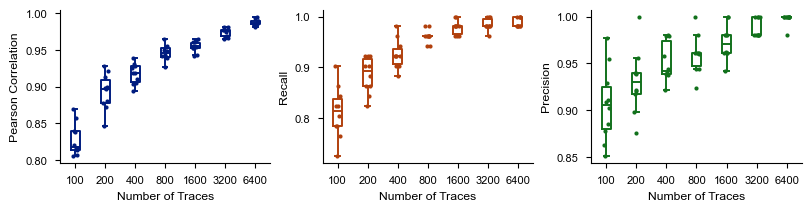

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2))


sns.stripplot(corr_df, x="num_cells", y="corr", linewidth=0, s=3, 
              color=sns.color_palette("dark")[0], ax=axes[0])
sns.boxplot(corr_df, x="num_cells", y="corr", width=0.3, fill=False,
            color=sns.color_palette("dark")[0], showfliers=False, ax=axes[0])
axes[0].set(xlabel="Number of Traces", ylabel="Pearson Correlation")
axes[0].grid(False)
sns.stripplot(prc_21, x="num_cells", y="recall", linewidth=0, s=3, 
              color=sns.color_palette("dark")[1], ax=axes[1])
sns.boxplot(prc_21, x="num_cells", y="recall", width=0.3, fill=False,
            color=sns.color_palette("dark")[1], showfliers=False, ax=axes[1])
axes[1].set(xlabel="Number of Traces", ylabel="Recall")
axes[1].grid(False)
sns.stripplot(prc_21, x="num_cells", y="precision", linewidth=0, s=3, 
              color=sns.color_palette("dark")[2], ax=axes[2])
sns.boxplot(prc_21, x="num_cells", y="precision", width=0.3, fill=False,
            color=sns.color_palette("dark")[2], showfliers=False, ax=axes[2])
axes[2].set(xlabel="Number of Traces", ylabel="Precision")
axes[2].grid(False)
fig.savefig(os.path.join(out_dire, "tad_replicate_21.pdf"), bbox_inches="tight")

In [35]:
d1df = adata.var.reset_index(drop=True)
d1df["c1"] = adata.uns["Chrom"]
d1df = d1df.rename(
    {"Chrom_Start": "s1", "Chrom_End": "e1"}, axis=1
)[["c1", "s1", "e1"]]
d1df

,c1,s1,e1
0,chr21,10400001,10450001
1,chr21,10500001,10550001
2,chr21,10600001,10650001
3,chr21,13250001,13300001
4,chr21,14000001,14050001
...,...,...,...
646,chr21,46450001,46500001
647,chr21,46500001,46550001
648,chr21,46550001,46600001
649,chr21,46600001,46650001


In [36]:
from utils.utils import _domain_chipseq_row
markers = up_rglt + down_rglt
d1df = adata.var.reset_index(drop=True)
d1df["c1"] = adata.uns["Chrom"]
d1df = d1df.rename(
    {"Chrom_Start": "s1", "Chrom_End": "e1"}, axis=1
)[["c1", "s1", "e1"]]
avg_rows = []
for marker in markers:
    avg_rows.append(_domain_chipseq_row(dtree, marker, d1df, "chipseq_imr90"))
avg_rows = pd.DataFrame(avg_rows)

rows = []
rep0 = reps[reps.replicate == 0].rename({"Chrom_Start": "s1", "Chrom_End": "e1"}, axis=1)
for n, df in rep0.groupby("num_cells"):
    print(n, np.sum(df.peak))
    for marker in markers:
        row = _domain_chipseq_row(dtree, marker, df[df.peak], dire="chipseq_imr90")
        row["num_cells"] = n
        rows.append(row)
rows = pd.DataFrame(rows)
enrich_df = pd.merge(rows, avg_rows, on=["marker"], how="left")
enrich_df["fold"] = np.log2(enrich_df["frac_x"]/enrich_df["frac_y"])
plt_df = enrich_df.pivot(index="num_cells", columns="marker", values="fold")
plt_df

100 44
200 49
400 48
800 52
1600 52
3200 51
6400 50


marker,CTCF,H3K36me3,H3K4me3,H3K9ac,H3K9me3,POLR2A,SMC3
num_cells,,,,,,,
100,0.484234,0.707758,0.547232,0.578960,-0.480988,0.782745,0.521901
200,0.672910,0.924449,0.639881,0.279292,-0.314338,0.627467,0.543500
400,0.565154,0.954196,0.814019,0.704968,-0.680519,0.920249,0.730789
800,0.542786,0.838719,0.829786,0.589490,-0.584492,0.804772,0.615312
1600,0.712711,0.964250,0.698541,0.405066,-0.400068,0.722310,0.564686
3200,0.615195,0.866733,0.793670,0.617505,-0.556478,0.662861,0.592700
6400,0.599370,0.895303,0.886369,0.702658,-0.527909,0.778893,0.514354


In [53]:
plt_df.loc[[100]]

marker,CTCF,H3K36me3,H3K4me3,H3K9ac,H3K9me3,POLR2A,SMC3
num_cells,,,,,,,
100,0.484234,0.707758,0.547232,0.57896,-0.480988,0.782745,0.521901


<Axes: xlabel='marker', ylabel='num_cells'>

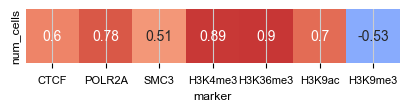

In [61]:
fig, ax = plt.subplots(figsize=(5, 1))
sns.heatmap(plt_df.loc[[n]][up_rglt+down_rglt], vmin=-1, vmax=1, annot=True, square=True,
                cmap="coolwarm", yticklabels=False, ax=ax, cbar=False)

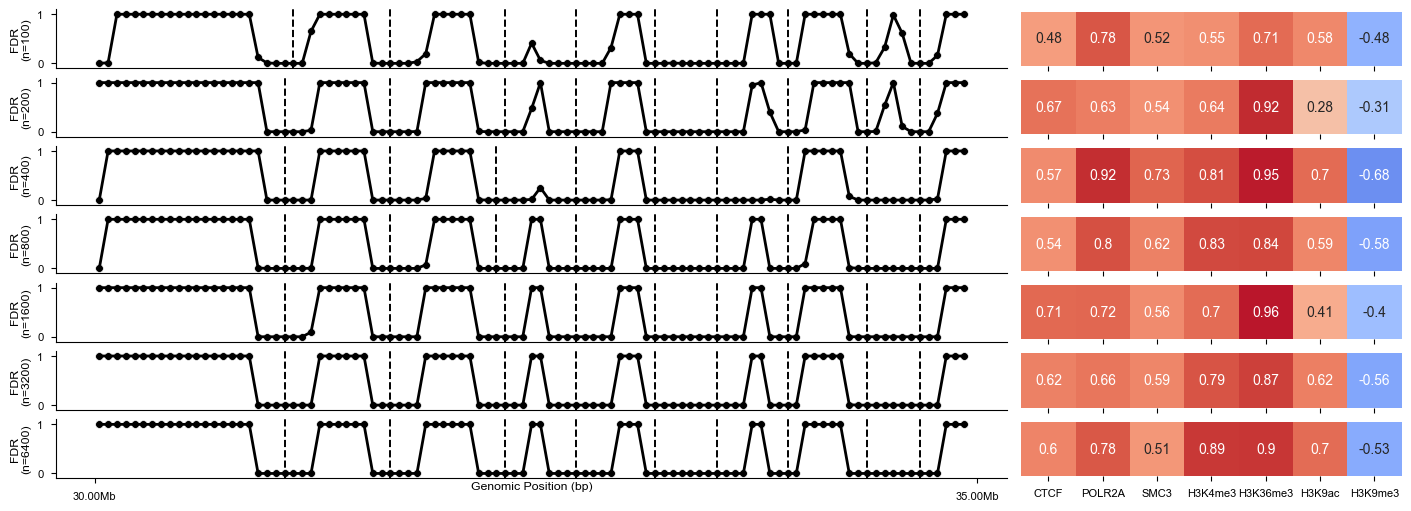

In [90]:
fig, axes = plt.subplots(7, 2, figsize=(14, 5), width_ratios=[10, 4])
s1d, e1d = 30e6, 35e6
for i, (n, df) in enumerate(rep0.groupby("num_cells")):
    df = df[(df["s1"]>=s1d)&(df["e1"]<=e1d)].copy()
    df["mid"] = (df["s1"] + df["e1"])/2
    sns.lineplot(df, x="mid", y="fdr", color="k", linewidth=2, ax=axes[i,0])
    sns.scatterplot(df, x="mid", y="fdr", color="k", ax=axes[i,0])
    axes[i,0].grid(False)
    axes[i,0].set(ylim=(-0.1, 1.1), ylabel=f"FDR\n(n={n})")
    for x in df[df.peak].mid:
        axes[i,0].axvline(x, ymin=0, ymax=1, linestyle="--", color="k", clip_on=False)
    sns.heatmap(plt_df.loc[[n]][up_rglt+down_rglt], vmin=-1, vmax=1, annot=True, square=True,
                cmap="coolwarm", yticklabels=False, ax=axes[i,1], cbar=False)
    axes[i,1].set(xlabel="", ylabel="")
    axes[i,1].grid(False)
    if i != 6:
        axes[i,0].set(xticks=[], xticklabels=[], xlabel="")
        axes[i,1].set(yticks=[], xticklabels=[])
    else:
        axes[i,0].set(
            xlabel="Genomic Position (bp)",
            xticks=[s1d, e1d],
            xticklabels=[f"{s1d/1e6:.2f}Mb", f"{e1d/1e6:.2f}Mb"]
        )
        axes[i,0].xaxis.set_label_coords(0.5, -.05)
fig.savefig(os.path.join(out_dire, "21_enrich_by_num.pdf"), bbox_inches="tight")

## Brain cell types

In [32]:
reps = ["rep1", "rep2", "rep3"]
loader = sf.pp.FOF_CT_Loader({
    c: dtree["takei_science_2021", "25Kb", c] for c in reps
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250}, obs_cols_add=["Cell_ID"])
celldfs = sf.pp.FOF_CT_Loader({
    c: dtree["takei_science_2021", "cell_type", c] for c in reps
}).read_data()

In [33]:
chr_id = "chr3"
adata = loader.create_adata(chr_id)
sf.pp.add_cell_type(adata, celldfs, "Cell_ID", "cluster label")
celltype_dict = {1:'Pvalb', 2:'Vip', 3:'Ndnf', 4:'Sst', 5:'Astro',
                 6:'Micro', 7:'Endo', 8:'Oligo', 9:'Ex'}
adata.obs["cell_type"] = adata.obs["cluster label"].map(celltype_dict)

In [34]:
adata[adata.obs["cell_type"]=="Ex"]

View of AnnData object with n_obs × n_vars = 2514 × 60
    obs: 'Cell_ID', 'cluster label', 'cell_type'
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'

## Differential TAD false positives

In [20]:
loader1 = sf.pp.FOF_CT_Loader({
    "rep1": dtree["takei_nature_2021", "25Kb", "rep1"]
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250})
loader2 = sf.pp.FOF_CT_Loader({
    "rep2": dtree["takei_nature_2021", "25Kb", "rep2"]
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250})


In [21]:
diff_res = []
for chr_id in loader1.chr_ids:
    adata1 = loader1.create_adata(chr_id)
    adata2 = loader2.create_adata(chr_id)
    diff = sf.tl.DiffRegion(adata1, adata2)
    diff_res.append(diff.diff_region(res_sf2))
diff_res = pd.concat(diff_res, ignore_index=True)

In [22]:
from statsmodels.stats import multitest as multi
diff_res["fdr"] = multi.multipletests(diff_res.pval, method="fdr_bh")[1]

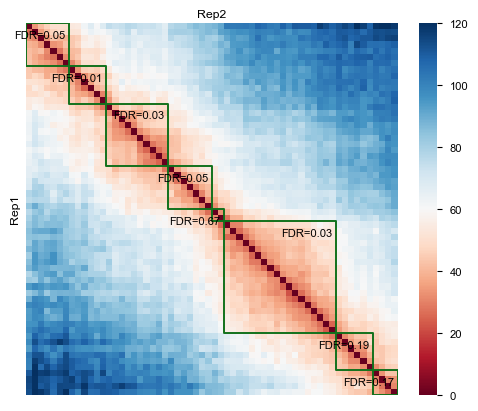

In [23]:
fig, ax = plt.subplots(figsize=(5, 4))
chr_id = "chr11"
adata1 = loader1.create_adata(chr_id)
adata2 = loader2.create_adata(chr_id)
sf.pl.pairwise_heatmap(
    X2=sf.pp.median_pdist(adata1, inplace=False),
    X1=sf.pp.median_pdist(adata2, inplace=False),
    y="Rep1", x="Rep2", ax=ax, vmax=120
)
diff = sf.tl.DiffRegion(adata1, adata2)
diff_res11 = diff.diff_region(res_sf2)
# sf.pl.pairwise_heatmap(diff.entry_pvals(adata1, adata2)[1])
sf.pl.add_domain_fdr(ax, diff_res11)

In [481]:
diff.entry_pvals(adata1, adata2).shape

(3, 60, 60)

In [482]:
diff_res["peak"] = diff_res.fdr < .05

In [460]:
diff_res.groupby("c1", sort=False).count()

,s1,e1,c2,s2,e2,stat1,stat2,level,idx1,idx2,stat,pval,fdr,log_fdr,size,peak
c1,,,,,,,,,,,,,,,,
chr1,6,6,6,6,6,5,5,6,6,6,6,6,6,6,6,6
chr2,6,6,6,6,6,5,5,6,6,6,6,6,6,6,6,6
chr3,7,7,7,7,7,6,6,7,7,7,7,7,7,7,7,7
chr4,8,8,8,8,8,7,7,8,8,8,8,8,8,8,8,8
chr5,5,5,5,5,5,4,4,5,5,5,5,5,5,5,5,5
chr6,5,5,5,5,5,4,4,5,5,5,5,5,5,5,5,5
chr7,8,8,8,8,8,7,7,8,8,8,8,8,8,8,8,8
chr8,4,4,4,4,4,3,3,4,4,4,4,4,4,4,4,4
chr9,9,9,9,9,9,8,8,9,9,9,9,9,9,9,9,9


In [459]:
diff_res.groupby("c1", sort=False)["peak"].sum()

c1
chr1     0
chr2     0
chr3     2
chr4     2
chr5     0
chr6     0
chr7     1
chr8     1
chr9     0
chr10    0
chr11    3
chr12    0
chr13    2
chr14    1
chr15    0
chr16    2
chr17    2
chr18    2
chr19    1
chrX     1
Name: peak, dtype: int64

<Axes: xlabel='size', ylabel='log_fdr'>

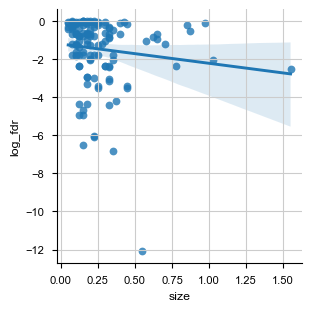

In [452]:
diff_res["size"] = (diff_res["s2"] - diff_res["s1"])/1e6
fig, ax = plt.subplots(figsize=(3, 3))
sns.regplot(diff_res, x="size", y="log_fdr", ax=ax)

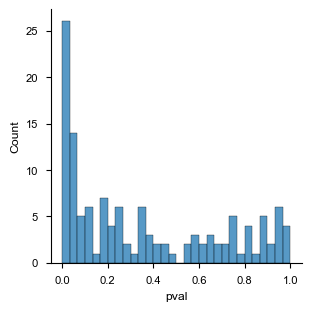

In [495]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.histplot(diff_res.pval, bins=30, ax=ax)
ax.grid(False)

In [491]:
(diff_res.fdr < .01).mean()

0.0390625